In [1]:
# Loading libraries

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## **TODO: Revised Model:**
- include casing features
- fix the all Os problem
- more plots -> conf matrix
- look for new metrics


**mistakes:**
- overfitting -> regularization
- all Os problem


**things to try:**
- regularization
- adjust model parameters
- adjust model structure
- batch normalization
- SMOT
- class weights

# Original Model

In [81]:
# Define the model
class NLPModel(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, num_pos_tags, pos_embedding_dim, num_embeddings_lemma, lemma_embedding_dim, hidden_dim, lstm_out_dim, output_dim):
        super(NLPModel, self).__init__()

        # Embedding layers
        self.word_embeddings = nn.Embedding(num_embeddings, embedding_dim)  # Pre-trained, frozen
        self.pos_embeddings = nn.Embedding(num_pos_tags, pos_embedding_dim)
        self.lemma_embedding = nn.Embedding(num_embeddings_lemma, lemma_embedding_dim)

        # Concatenation dimension
        concat_dim = embedding_dim + pos_embedding_dim + lemma_embedding_dim

        # Dense layer prior to LSTM
        self.dense = nn.Linear(concat_dim, hidden_dim)

        # LSTM layer
        self.lstm = nn.LSTM(hidden_dim, lstm_out_dim, batch_first=True, bidirectional=True)

        # Output layer
        self.output_layer = nn.Linear(2 * lstm_out_dim, output_dim)  # Correct input dimension

        # Dropout layer
        self.dropout = nn.Dropout(0.25)

    def forward(self, x, pos, lemma):
        # Embed each input type
        x = self.word_embeddings(x)
        pos = self.pos_embeddings(pos)
        lemma = self.lemma_embedding(lemma)

        # Concatenate embeddings
        x = torch.cat((x, pos, lemma), dim=-1)

        # Apply dense and activation
        x = torch.tanh(self.dense(x))

        # Apply dropout
        x = self.dropout(x)

        # LSTM layer
        lstm_out, _ = self.lstm(x)

        # Output layer
        output = self.output_layer(lstm_out)

        return output

## Dataloading

In [82]:
 # Load the CSV file
file_path = '/content/feature_extracted_data.csv'
df = pd.read_csv(file_path)

# Encoding categorical columns
word_encoder = LabelEncoder()
pos_encoder = LabelEncoder()
lemma_encoder = LabelEncoder()
tag_encoder = LabelEncoder()

df['Word_idx'] = word_encoder.fit_transform(df['Word'])
df['POS_idx'] = pos_encoder.fit_transform(df['POS'])
df['Lemma_idx'] = lemma_encoder.fit_transform(df['LEMMA'])
df['Tag_idx'] = tag_encoder.fit_transform(df['Tag'])

# Add 'unknown' index for words, lemmas, and tags
def add_unknown_to_encoder(encoder):
    classes = list(encoder.classes_)
    if 'unknown' not in classes:
        classes.append('unknown')
        encoder.classes_ = np.array(classes)
    return encoder

word_encoder = add_unknown_to_encoder(word_encoder)
lemma_encoder = add_unknown_to_encoder(lemma_encoder)
tag_encoder = add_unknown_to_encoder(tag_encoder)

# Function to map words/lemmas/tags to their indices, using 'unknown' for unseen labels
def map_to_index(encoder, items, unknown_label='unknown'):
    label_map = {label: idx for idx, label in enumerate(encoder.classes_)}
    return [label_map.get(item, label_map[unknown_label]) for item in items]

df['Word_idx'] = map_to_index(word_encoder, df['Word'])
df['Lemma_idx'] = map_to_index(lemma_encoder, df['LEMMA'])
df['Tag_idx'] = map_to_index(tag_encoder, df['Tag'])

In [83]:
# Custom Dataset class
class NLPCustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        word = self.dataframe.iloc[idx]['Word_idx']
        pos = self.dataframe.iloc[idx]['POS_idx']
        lemma = self.dataframe.iloc[idx]['Lemma_idx']
        tag = self.dataframe.iloc[idx]['Tag_idx']

        sample = {
            'word': torch.tensor(word, dtype=torch.long),
            'pos': torch.tensor(pos, dtype=torch.long),
            'lemma': torch.tensor(lemma, dtype=torch.long),
            'tag': torch.tensor(tag, dtype=torch.long)
        }
        return sample

# Splitting data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Creating Dataset and DataLoader for training and validation
train_dataset = NLPCustomDataset(train_df)
val_dataset = NLPCustomDataset(val_df)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## Parameter initialization

In [84]:
# Initializing the model
model = NLPModel(
    num_embeddings=len(word_encoder.classes_),
    embedding_dim=50,
    num_pos_tags=len(pos_encoder.classes_),
    pos_embedding_dim=10,
    num_embeddings_lemma=len(lemma_encoder.classes_),
    lemma_embedding_dim=10,
    hidden_dim=100,
    lstm_out_dim=50,
    output_dim=len(tag_encoder.classes_)
).to(device)

# Defining loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
train_losses = []
val_losses = []

## Trianing Loop

In [85]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        words = batch['word'].to(device)
        pos = batch['pos'].to(device)
        lemma = batch['lemma'].to(device)
        tags = batch['tag'].to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(words, pos, lemma)

        # Compute loss
        loss = criterion(outputs.view(-1, outputs.shape[-1]), tags.view(-1))

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_loss)
    print(f'\nEpoch {epoch+1}/{num_epochs}, Loss: {avg_loss}')

    # Validation step (optional)
    model.eval()
    val_loss = 0
    correct_predictions = 0
    total_predictions = 0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for batch in val_dataloader:
            words = batch['word'].to(device)
            pos = batch['pos'].to(device)
            lemma = batch['lemma'].to(device)
            tags = batch['tag'].to(device)

            # Forward pass
            outputs = model(words, pos, lemma)

            # Compute loss
            loss = criterion(outputs.view(-1, outputs.shape[-1]), tags.view(-1))
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, -1)
            correct_predictions += (predicted == tags).sum().item()
            total_predictions += tags.numel()

            all_val_preds.extend(predicted.cpu().numpy().flatten())
            all_val_labels.extend(tags.cpu().numpy().flatten())

    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    val_accuracy = correct_predictions / total_predictions

    val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(all_val_labels, all_val_preds, average='weighted',zero_division=0)
    print(f'Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy}')
    print(f'Validation Precision: {val_precision}, Recall: {val_recall}, F1 Score: {val_f1}')


Epoch 1/10, Loss: 0.3338369301535946
Validation Loss: 0.27900083609292226, Validation Accuracy: 0.9236189235597134
Validation Precision: 0.906956789974471, Recall: 0.9236189235597134, F1 Score: 0.9024188916328366

Epoch 2/10, Loss: 0.2661989182771918
Validation Loss: 0.2618808309780434, Validation Accuracy: 0.9266386405352597
Validation Precision: 0.9094096634321499, Recall: 0.9266386405352597, F1 Score: 0.908817211589181

Epoch 3/10, Loss: 0.24159847729511447
Validation Loss: 0.25633857714075764, Validation Accuracy: 0.9274083723133401
Validation Precision: 0.9193484092495449, Recall: 0.9274083723133401, F1 Score: 0.9132036667349201

Epoch 4/10, Loss: 0.226083397936749
Validation Loss: 0.25694940562684543, Validation Accuracy: 0.9257208834152407
Validation Precision: 0.9178543469812077, Recall: 0.9257208834152407, F1 Score: 0.914388430540816

Epoch 5/10, Loss: 0.21522019537954837
Validation Loss: 0.2568559627415556, Validation Accuracy: 0.9241518147906922
Validation Precision: 0.9117

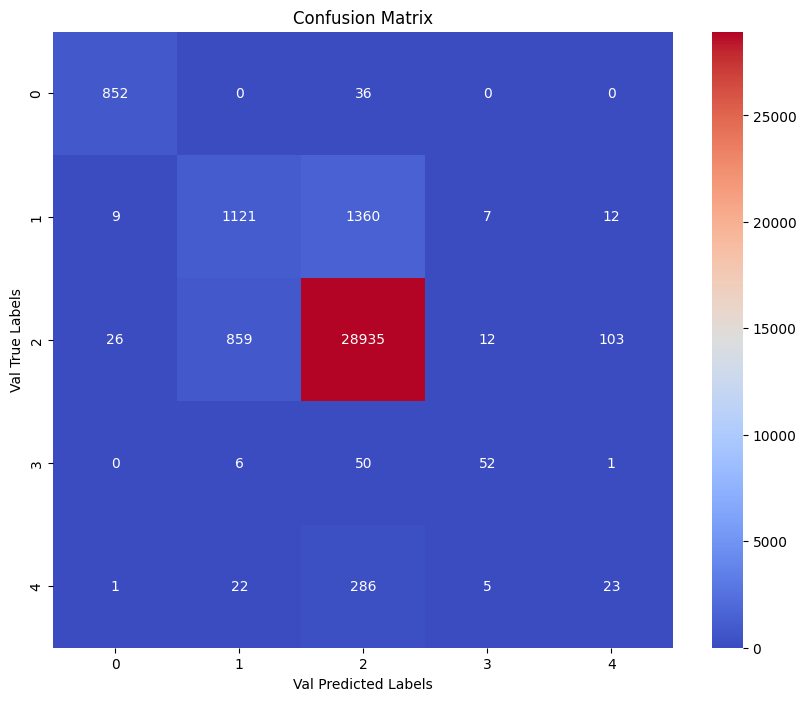

In [86]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(all_val_labels, all_val_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Val Predicted Labels')
plt.ylabel('Val True Labels')
plt.title('Confusion Matrix')
plt.show()

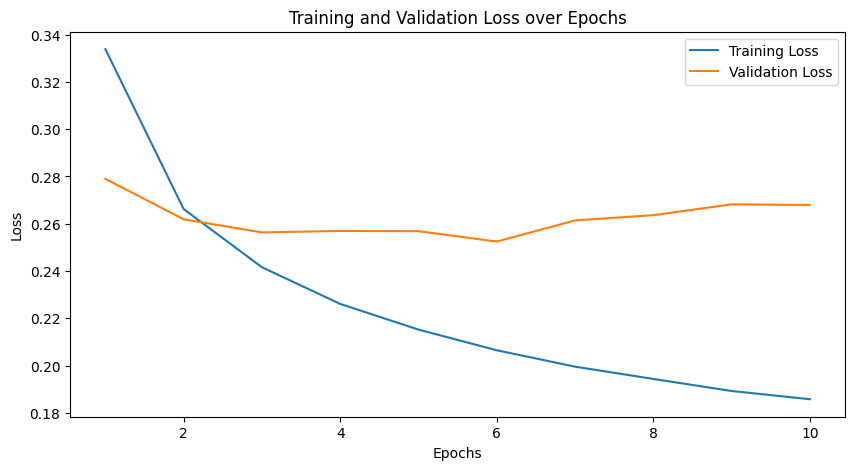

In [87]:
# Plotting training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')
plt.show()

In [88]:
# Print some example predictions
print("\nSample Predictions:")
for i in range(100):
    true_label = tag_encoder.inverse_transform([all_val_labels[i]])[0]
    predicted_label = tag_encoder.inverse_transform([all_val_preds[i]])[0]
    print(f"True Label: {true_label}, Predicted Label: {predicted_label}")


Sample Predictions:
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: NEG, Predicted Label: NEG
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: NSCO
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: NSCO, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: NSCO, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O,

## Testing

## Dataloading Test Set

In [89]:
# Load the test CSV file
test_file_path = '/content/feature_extracted_dataTEST.csv'
df_test = pd.read_csv(test_file_path)

# Encoding categorical columns
word_encoder = LabelEncoder()
pos_encoder = LabelEncoder()
lemma_encoder = LabelEncoder()
tag_encoder = LabelEncoder()

df_test['Word_idx'] = word_encoder.fit_transform(df_test['Word'])
df_test['POS_idx'] = pos_encoder.fit_transform(df_test['POS'])
df_test['Lemma_idx'] = lemma_encoder.fit_transform(df_test['LEMMA'])
df_test['Tag_idx'] = tag_encoder.fit_transform(df_test['Tag'])

word_encoder = add_unknown_to_encoder(word_encoder)
lemma_encoder = add_unknown_to_encoder(lemma_encoder)
tag_encoder = add_unknown_to_encoder(tag_encoder)

df_test['Word_idx'] = map_to_index(word_encoder, df_test['Word'])
df_test['Lemma_idx'] = map_to_index(lemma_encoder, df_test['LEMMA'])
df_test['Tag_idx'] = map_to_index(tag_encoder, df_test['Tag'])


# Custom Dataset class for test data
class NLPCustomTestDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        word = self.dataframe.iloc[idx]['Word_idx']
        pos = self.dataframe.iloc[idx]['POS_idx']
        lemma = self.dataframe.iloc[idx]['Lemma_idx']
        tag = self.dataframe.iloc[idx]['Tag_idx']

        sample = {
            'word': torch.tensor(word, dtype=torch.long),
            'pos': torch.tensor(pos, dtype=torch.long),
            'lemma': torch.tensor(lemma, dtype=torch.long),
            'tag': torch.tensor(tag, dtype=torch.long)
        }
        return sample

# Create Dataset and DataLoader for test data
test_dataset = NLPCustomTestDataset(df_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Model Evaluation

In [91]:
# Evaluate the model on the test data
model.eval()
test_loss = 0
correct_predictions = 0
total_predictions = 0
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        words = batch['word'].to(device)
        pos = batch['pos'].to(device)
        lemma = batch['lemma'].to(device)
        tags = batch['tag'].to(device)

        # Forward pass
        outputs = model(words, pos, lemma)

        # Compute loss
        loss = criterion(outputs.view(-1, outputs.shape[-1]), tags.view(-1))
        test_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, -1)
        correct_predictions += (predicted == tags).sum().item()
        total_predictions += tags.numel()

        all_test_preds.extend(predicted.cpu().numpy().flatten())
        all_test_labels.extend(tags.cpu().numpy().flatten())

avg_test_loss = test_loss / len(test_dataloader)
test_accuracy = correct_predictions / total_predictions

test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(all_test_labels, all_test_preds, average='weighted', zero_division=0)

print(f'Test Loss: {avg_test_loss}, Test Accuracy: {test_accuracy}')
print(f'Test Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}')

Test Loss: 0.7039735036678639, Test Accuracy: 0.8473204104903078
Test Precision: 0.7988553538357142, Recall: 0.8473204104903078, F1 Score: 0.8219930933995283


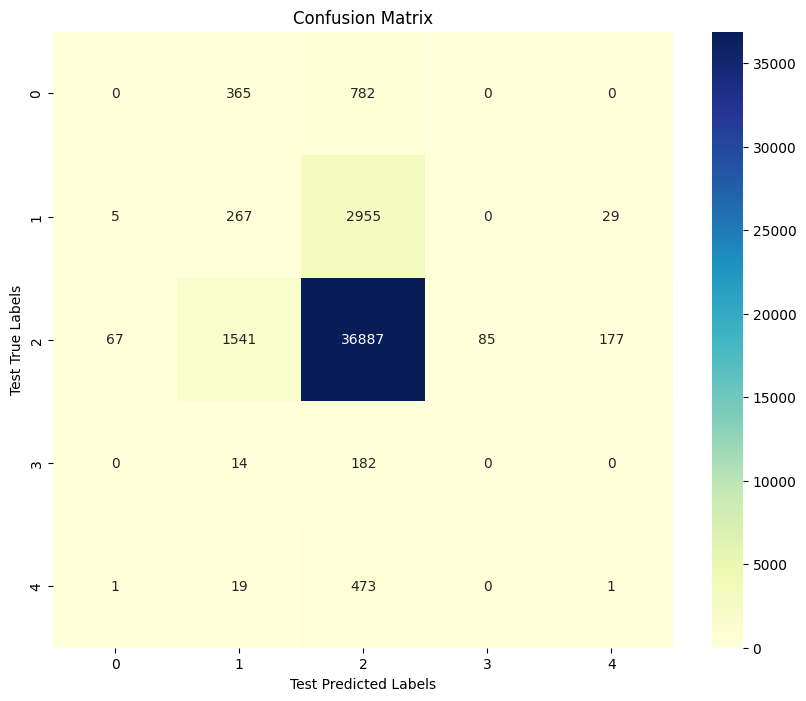

In [92]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(all_test_labels, all_test_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Test Predicted Labels')
plt.ylabel('Test True Labels')
plt.title('Confusion Matrix')
plt.show()

In [93]:
# Print some example predictions
print("\nSample Predictions:")
for i in range(100):
    true_label = tag_encoder.inverse_transform([all_test_labels[i]])[0]
    predicted_label = tag_encoder.inverse_transform([all_test_preds[i]])[0]
    print(f"True Label: {true_label}, Predicted Label: {predicted_label}")


Sample Predictions:
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: NSCO
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: NEG, Predicted Label: O
True Label: NSCO, Predicted Label: O
True Label: NSCO, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: NEG, Predicted Label: O
True Label: NSCO, Predicted Label: O
True Label: NSCO, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: NSCO
True 

# Revised Model

Including
- Regularization
- Class weights



## Model - Revised

In [41]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [56]:
class NLPModel(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, num_pos_tags, pos_embedding_dim, num_embeddings_lemma, lemma_embedding_dim, hidden_dim, lstm_out_dim, output_dim):
        super(NLPModel, self).__init__()

        # Embedding layers
        self.word_embeddings = nn.Embedding(num_embeddings, embedding_dim)
        self.pos_embeddings = nn.Embedding(num_pos_tags, pos_embedding_dim)
        self.lemma_embedding = nn.Embedding(num_embeddings_lemma, lemma_embedding_dim)

        # Concatenation dimension
        concat_dim = embedding_dim + pos_embedding_dim + lemma_embedding_dim

        # Dense layer prior to LSTM
        self.dense = nn.Linear(concat_dim, hidden_dim)

        # LSTM layer
        self.lstm = nn.LSTM(hidden_dim, lstm_out_dim, batch_first=True, bidirectional=True)

        # Output layer
        self.output_layer = nn.Linear(2 * lstm_out_dim, output_dim)

        # Dropout layer
        self.dropout = nn.Dropout(0.5)  # Increased dropout for regularization

    def forward(self, x, pos, lemma):
        # Embed each input type
        x = self.word_embeddings(x)
        pos = self.pos_embeddings(pos)
        lemma = self.lemma_embedding(lemma)

        # Concatenate embeddings
        x = torch.cat((x, pos, lemma), dim=-1)

        # Apply dense layer
        x = torch.tanh(self.dense(x))

        # Apply dropout
        x = self.dropout(x)

        # LSTM layer
        lstm_out, _ = self.lstm(x)

        # Output layer
        output = self.output_layer(lstm_out)

        return output

## Revised Data Loading

In [57]:
# Load data and preprocess
train_data = pd.read_csv('/content/feature_extracted_data.csv')
test_data = pd.read_csv('/content/feature_extracted_dataTEST.csv')

# Function to add 'unknown' to encoder
def add_unknown_to_encoder(encoder):
    classes = list(encoder.classes_)
    if 'unknown' not in classes:
        classes.append('unknown')
        encoder.classes_ = np.array(classes)
    return encoder

# Function to map items to indices with unknown handling
def map_to_index(encoder, items, unknown_label='unknown'):
    label_map = {label: idx for idx, label in enumerate(encoder.classes_)}
    return [label_map.get(item, label_map[unknown_label]) for item in items]

# Encode labels
tag_encoder = LabelEncoder()
train_data['Tag'] = tag_encoder.fit_transform(train_data['Tag'])
tag_encoder = add_unknown_to_encoder(tag_encoder)

# Encode words, POS, and lemma
word_encoder = LabelEncoder()
pos_encoder = LabelEncoder()
lemma_encoder = LabelEncoder()

train_data['Word'] = word_encoder.fit_transform(train_data['Word'])
train_data['POS'] = pos_encoder.fit_transform(train_data['POS'])
train_data['LEMMA'] = lemma_encoder.fit_transform(train_data['LEMMA'])

word_encoder = add_unknown_to_encoder(word_encoder)
lemma_encoder = add_unknown_to_encoder(lemma_encoder)

# Transform test data
test_data['Word'] = map_to_index(word_encoder, test_data['Word'])
test_data['POS'] = pos_encoder.transform(test_data['POS'])  # POS should not have unknowns
test_data['LEMMA'] = map_to_index(lemma_encoder, test_data['LEMMA'])
test_data['Tag'] = map_to_index(tag_encoder, test_data['Tag'])

# Split training data into train and validation sets
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

# Create datasets and dataloaders
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        return {
            'word': torch.tensor(item['Word'], dtype=torch.long),
            'pos': torch.tensor(item['POS'], dtype=torch.long),
            'lemma': torch.tensor(item['LEMMA'], dtype=torch.long),
            'label': torch.tensor(item['Tag'], dtype=torch.long)
        }

train_dataset = CustomDataset(train_data)
val_dataset = CustomDataset(val_data)
test_dataset = CustomDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Calculate class weights
class_counts = train_data['Tag'].value_counts().sort_index()
class_weights = 1. / class_counts
class_weights = class_weights / class_weights.sum()
class_weights = torch.tensor(class_weights.values, dtype=torch.float)

# Ensure the class weights match the number of classes
if len(class_weights) != len(tag_encoder.classes_):
    class_weights = torch.cat([class_weights, torch.tensor([1.0], dtype=torch.float)])

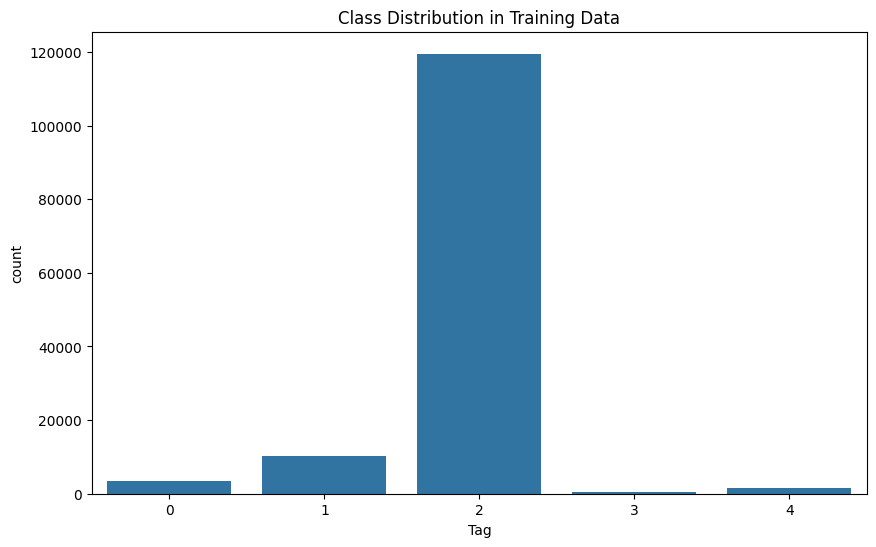

In [58]:
# Plotting class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Tag', data=train_data)
plt.title('Class Distribution in Training Data')
plt.show()

In [59]:
# Initialize model, criterion, and optimizer
num_embeddings = len(word_encoder.classes_)
embedding_dim = 100
num_pos_tags = len(pos_encoder.classes_)
pos_embedding_dim = 25
num_embeddings_lemma = len(lemma_encoder.classes_)
lemma_embedding_dim = 25
hidden_dim = 128
lstm_out_dim = 64
output_dim = len(tag_encoder.classes_)

model = NLPModel(num_embeddings, embedding_dim, num_pos_tags, pos_embedding_dim, num_embeddings_lemma, lemma_embedding_dim, hidden_dim, lstm_out_dim, output_dim).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
train_losses = []
val_losses = []

## Revised Training Loop

In [62]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        words = batch['word'].to(device)
        pos = batch['pos'].to(device)
        lemma = batch['lemma'].to(device)
        tags = batch['tag'].to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(words, pos, lemma)

        # Compute loss
        loss = criterion(outputs.view(-1, outputs.shape[-1]), tags.view(-1))

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_loss)
    print(f'\nEpoch {epoch+1}/{num_epochs}, Loss: {avg_loss}')

    model.eval()
    val_loss = 0
    correct_predictions = 0
    total_predictions = 0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for batch in val_dataloader:
            words = batch['word'].to(device)
            pos = batch['pos'].to(device)
            lemma = batch['lemma'].to(device)
            tags = batch['tag'].to(device)

            # Forward pass
            outputs = model(words, pos, lemma)

            # Compute loss
            loss = criterion(outputs.view(-1, outputs.shape[-1]), tags.view(-1))
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, -1)
            correct_predictions += (predicted == tags).sum().item()
            total_predictions += tags.numel()

            all_val_preds.extend(predicted.cpu().numpy().flatten())
            all_val_labels.extend(tags.cpu().numpy().flatten())

    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    val_accuracy = correct_predictions / total_predictions

    val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(all_val_labels, all_val_preds, average='weighted',zero_division=0)
    print(f'Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy}')
    print(f'Validation Precision: {val_precision}, Recall: {val_recall}, F1 Score: {val_f1}')


Epoch 1/10, Loss: 0.5926141703641163
Validation Loss: 0.7631556438493796, Validation Accuracy: 0.7401859198294748
Validation Precision: 0.9011909104133408, Recall: 0.7401859198294748, F1 Score: 0.8011198508651163

Epoch 2/10, Loss: 0.5534034338489743
Validation Loss: 0.793900701062133, Validation Accuracy: 0.7687844158920007
Validation Precision: 0.9008400371133031, Recall: 0.7687844158920007, F1 Score: 0.8192793633896744

Epoch 3/10, Loss: 0.5376540234895952
Validation Loss: 0.7734345171254862, Validation Accuracy: 0.7989223755106875
Validation Precision: 0.8991583662744198, Recall: 0.7989223755106875, F1 Score: 0.8390961902790104

Epoch 4/10, Loss: 0.5120491677131693
Validation Loss: 0.791677466886485, Validation Accuracy: 0.7069394280300787
Validation Precision: 0.9053628247664243, Recall: 0.7069394280300787, F1 Score: 0.7775553777527971

Epoch 5/10, Loss: 0.5016163845473546
Validation Loss: 0.8290794347483439, Validation Accuracy: 0.74270235064243
Validation Precision: 0.908465362

Plotting

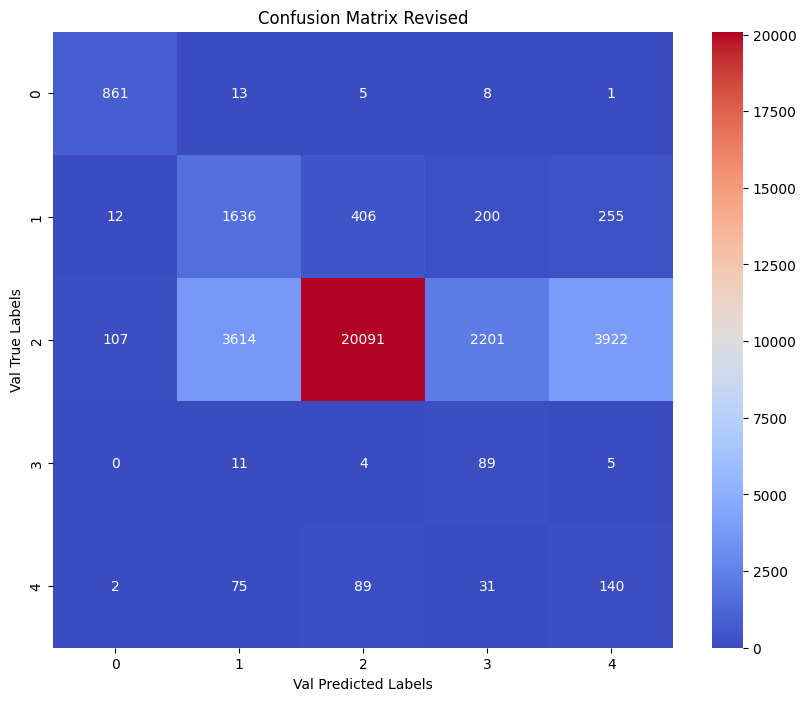

In [67]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(all_val_labels, all_val_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Val Predicted Labels')
plt.ylabel('Val True Labels')
plt.title('Confusion Matrix Revised')
plt.show()

In [66]:
# Print some example predictions
print("\nSample Predictions:")
for i in range(100):
    true_label = tag_encoder.inverse_transform([all_val_labels[i]])[0]
    predicted_label = tag_encoder.inverse_transform([all_val_preds[i]])[0]
    print(f"True Label: {true_label}, Predicted Label: {predicted_label}")


Sample Predictions:
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: NEG, Predicted Label: NEG
True Label: O, Predicted Label: USCO
True Label: O, Predicted Label: O
True Label: O, Predicted Label: NSCO
True Label: O, Predicted Label: O
True Label: O, Predicted Label: NSCO
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: USCO
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: NSCO, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: USCO
True Label: O, Predicted Label: O
True Label: O, Predicted Label: NSCO
True Label: NSCO, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: USCO
True Label: O, Predicted Label

### Revised Testing

In [71]:
# Evaluate the model on the test data
model.eval()
test_loss = 0
correct_predictions = 0
total_predictions = 0
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for batch in test_loader:
        words = batch['word'].to(device)
        pos = batch['pos'].to(device)
        lemma = batch['lemma'].to(device)
        tags = batch['label'].to(device)

        # Forward pass
        outputs = model(words, pos, lemma)

        # Compute loss
        loss = criterion(outputs.view(-1, outputs.shape[-1]), tags.view(-1))
        test_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, -1)
        correct_predictions += (predicted == tags).sum().item()
        total_predictions += tags.numel()

        all_test_preds.extend(predicted.cpu().numpy().flatten())
        all_test_labels.extend(tags.cpu().numpy().flatten())

avg_test_loss = test_loss / len(test_loader)
test_accuracy = correct_predictions / total_predictions

test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(all_test_labels, all_test_preds, average='weighted', zero_division=0)

print(f'Test Loss: {avg_test_loss}, Test Accuracy: {test_accuracy}')
print(f'Test Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}')

Test Loss: 0.7002829347680114, Test Accuracy: 0.7455644241733181
Test Precision: 0.9080259312009991, Recall: 0.7455644241733181, F1 Score: 0.8096475403794715


Plotting

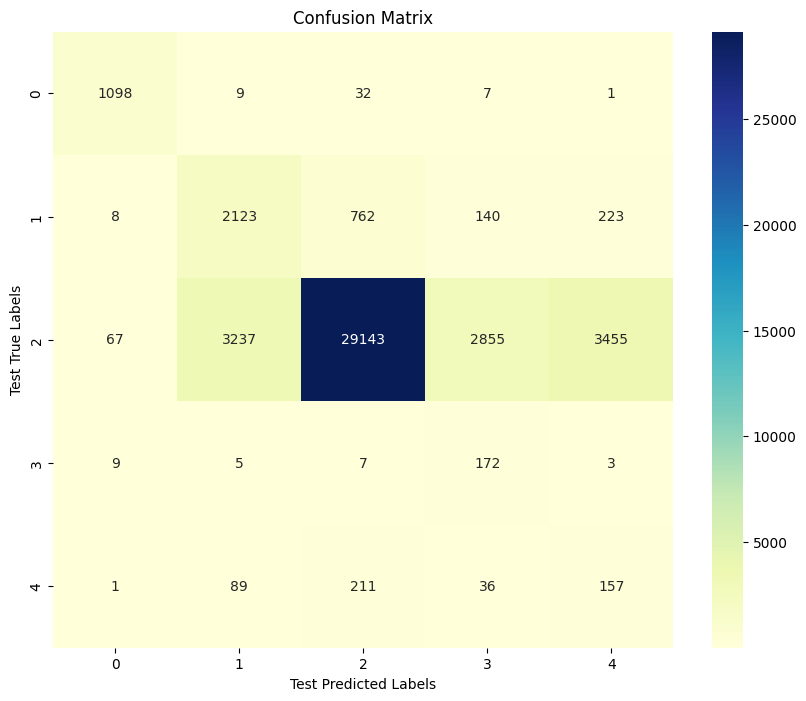

In [72]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(all_test_labels, all_test_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Test Predicted Labels')
plt.ylabel('Test True Labels')
plt.title('Confusion Matrix')
plt.show()

In [73]:
# Print some example predictions
print("\nSample Predictions:")
for i in range(100):
    true_label = tag_encoder.inverse_transform([all_test_labels[i]])[0]
    predicted_label = tag_encoder.inverse_transform([all_test_preds[i]])[0]
    print(f"True Label: {true_label}, Predicted Label: {predicted_label}")


Sample Predictions:
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: USCO
True Label: O, Predicted Label: USCO
True Label: O, Predicted Label: O
True Label: O, Predicted Label: NSCO
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: USCO
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: NEG, Predicted Label: NEG
True Label: NSCO, Predicted Label: NSCO
True Label: NSCO, Predicted Label: NSCO
True Label: O, Predicted Label: NSCO
True Label: O, Predicted Label: O
True Label: O, Predicted Label: NSCO
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Label: O, Predicted Label: USCO
True Label: NEG, Predicted Label: NEG
True Label: NSCO, Predicted Label: NSCO
True Label: NSCO, Predicted Label: NSCO
True Label: O, Predicted Label: O
True Label: O, Predicted Label: O
True Lab

# Training with Case Tagging Features

In [74]:
# Load the data
train_data_path = '/content/feature_extracted_data.csv'
test_data_path = '/content/feature_extracted_dataTEST.csv'

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

# Define the dataset class
class NLPDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.word_encoder = LabelEncoder().fit(data['Word'])
        self.pos_encoder = LabelEncoder().fit(data['POS'])
        self.lemma_encoder = LabelEncoder().fit(data['LEMMA'])
        self.tag_encoder = LabelEncoder().fit(data['Tag'])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        word = self.word_encoder.transform([self.data.iloc[idx]['Word']])[0]
        pos = self.pos_encoder.transform([self.data.iloc[idx]['POS']])[0]
        lemma = self.lemma_encoder.transform([self.data.iloc[idx]['LEMMA']])[0]
        number = self.data.iloc[idx]['NUMBER']
        contains_number = self.data.iloc[idx]['Contains NUMBER']
        maj_number = self.data.iloc[idx]['Maj NUMBER']
        tag = self.tag_encoder.transform([self.data.iloc[idx]['Tag']])[0]
        return {
            'word': torch.tensor(word, dtype=torch.long),
            'pos': torch.tensor(pos, dtype=torch.long),
            'lemma': torch.tensor(lemma, dtype=torch.long),
            'number': torch.tensor(number, dtype=torch.float),
            'contains_number': torch.tensor(contains_number, dtype=torch.float),
            'maj_number': torch.tensor(maj_number, dtype=torch.float),
            'tag': torch.tensor(tag, dtype=torch.long)
        }

# Create dataset and dataloader
train_dataset = NLPDataset(train_data)
test_dataset = NLPDataset(test_data)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [79]:
# Define the model
class NLPModel(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, num_pos_tags, pos_embedding_dim, num_embeddings_lemma, lemma_embedding_dim, hidden_dim, lstm_out_dim, output_dim):
        super(NLPModel, self).__init__()

        # Embedding layers
        self.word_embeddings = nn.Embedding(num_embeddings, embedding_dim)
        self.pos_embeddings = nn.Embedding(num_pos_tags, pos_embedding_dim)
        self.lemma_embeddings = nn.Embedding(num_embeddings_lemma, lemma_embedding_dim)

        # Feature weight
        self.feature_weight = 0.1  # To reduce their impact

        # Concatenation dimension
        concat_dim = embedding_dim + pos_embedding_dim + lemma_embedding_dim + 3  # 3 for the additional features

        # Dense layer prior to LSTM
        self.dense = nn.Linear(concat_dim, hidden_dim)

        # LSTM layer
        self.lstm = nn.LSTM(hidden_dim, lstm_out_dim, batch_first=True, bidirectional=True)

        # Output layer
        self.output_layer = nn.Linear(2 * lstm_out_dim, output_dim)

    def forward(self, word_input, pos_input, lemma_input, number, contains_number, maj_number):
        word_embeds = self.word_embeddings(word_input)
        pos_embeds = self.pos_embeddings(pos_input)
        lemma_embeds = self.lemma_embeddings(lemma_input)

        # Apply weight to number features
        number = number * self.feature_weight
        contains_number = contains_number * self.feature_weight
        maj_number = maj_number * self.feature_weight

        # Concatenate all features
        combined = torch.cat((word_embeds, pos_embeds, lemma_embeds, number.unsqueeze(-1), contains_number.unsqueeze(-1), maj_number.unsqueeze(-1)), dim=-1)

        # Dense layer
        dense_out = self.dense(combined)

        # LSTM layer
        lstm_out, _ = self.lstm(dense_out)

        # Output layer
        output = self.output_layer(lstm_out)

        return output

In [80]:
# Initialize the model, criterion, and optimizer
model = NLPModel(num_embeddings=len(train_dataset.word_encoder.classes_),
                 embedding_dim=100,
                 num_pos_tags=len(train_dataset.pos_encoder.classes_),
                 pos_embedding_dim=25,
                 num_embeddings_lemma=len(train_dataset.lemma_encoder.classes_),
                 lemma_embedding_dim=25,
                 hidden_dim=128,
                 lstm_out_dim=64,
                 output_dim=len(train_dataset.tag_encoder.classes_)).to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with progress bar
num_epochs = 10
batch_size = 16  # Reduced batch size for more frequent updates
from tqdm import tqdm  # Progress bar library

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    num_batches = len(train_dataloader)

    # Using tqdm for the progress bar
    with tqdm(total=num_batches, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as pbar:
        for batch_idx, batch in enumerate(train_dataloader):
            words = batch['word'].to(device)
            pos = batch['pos'].to(device)
            lemma = batch['lemma'].to(device)
            number = batch['number'].to(device)
            contains_number = batch['contains_number'].to(device)
            maj_number = batch['maj_number'].to(device)
            tags = batch['tag'].to(device)

            optimizer.zero_grad()
            outputs = model(words, pos, lemma, number, contains_number, maj_number)
            loss = criterion(outputs.view(-1, outputs.shape[-1]), tags.view(-1))
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            pbar.set_postfix({'Loss': epoch_loss / (batch_idx + 1)})
            pbar.update(1)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / num_batches}')

# Evaluate the model on the test data
model.eval()
test_loss = 0
correct_predictions = 0
total_predictions = 0
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        words = batch['word'].to(device)
        pos = batch['pos'].to(device)
        lemma = batch['lemma'].to(device)
        number = batch['number'].to(device)
        contains_number = batch['contains_number'].to(device)
        maj_number = batch['maj_number'].to(device)
        tags = batch['tag'].to(device)

        outputs = model(words, pos, lemma, number, contains_number, maj_number)
        loss = criterion(outputs.view(-1, outputs.shape[-1]), tags.view(-1))
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, -1)
        correct_predictions += (predicted == tags).sum().item()
        total_predictions += tags.numel()

        all_test_preds.extend(predicted.cpu().numpy().flatten())
        all_test_labels.extend(tags.cpu().numpy().flatten())

avg_test_loss = test_loss / len(test_dataloader)
test_accuracy = correct_predictions / total_predictions

test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(all_test_labels, all_test_preds, average='weighted', zero_division=0)

print(f'Test Loss: {avg_test_loss}, Test Accuracy: {test_accuracy}')
print(f'Test Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}')

Epoch 1/10:   0%|          | 20/5278 [00:20<1:27:56,  1.00s/batch, Loss=1.09]


KeyboardInterrupt: 